### Importing the libraries:

In [122]:
#log add data preprocessing and remove dropout for testing
#Load necessary library
import numpy as np
from scipy import misc
import tensorflow as tf
import os;
import matplotlib.pyplot as plt
import h5py
import time
# number of sample
# import cv2

##### Loading the data

In [123]:
#Read data from pickle file
import six.moves.cPickle as pickle
import os
import sys
import gzip
data_dir = 'C:\\Users\\Mert Ketenci\\Desktop\\train\\train\\'
data_dir=os.getcwd()
output_file = 'trainpkl.gz'
out_path = os.path.join("C:\\Users\\Mert Ketenci\\Desktop\\train\\train\\", output_file)
f_test = gzip.open(out_path, 'rb')
test_set = pickle.load(f_test)
f_test.close()
# print (test_set)

###### We are going to create labels and length. For this model we are going to use digits that are smaller than or equal to 99. Because the output size is going to have 10^(number of digits), this will cause us to have 100 softmax outputs.

In [124]:
label = test_set["labels"]

In [126]:
label_train=[]
Pic_crop_Final=[]
for i in range(test_set['images'].shape[0]):
    if len(label[i])<=2:
        label_train.append(label[i])
        Pic_crop_Final.append(test_set["images"][i])
Pic_crop_Final = np.asarray(Pic_crop_Final)
Pic_crop_Final = Pic_crop_Final.reshape(-1,54,54,3)

##### Let's plot the number and label corresponding to number

19


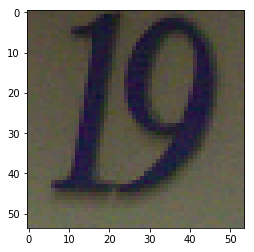

In [127]:
print(label_train[0])
plt.imshow(Pic_crop_Final[0])

##### We need to have labels as integers to be able to one hot encode them as sample*number class

In [128]:
label_train_int=[]
for i in range(len(label_train)):
    label_train_int.append(int(''.join(str(v) for v in label_train[i])))

In [129]:
#To one hot encoding
Train_no = Pic_crop_Final.shape[0]
thats_hot=np.zeros((Train_no-1,100), dtype=int)
for i in range(Train_no-1):
    thats_hot[i][label_train_int[i]]=1

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


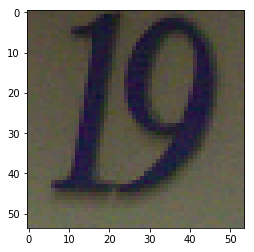

In [130]:
print(thats_hot[0])
plt.imshow(Pic_crop_Final[0])

##### Divide set into training and validation set

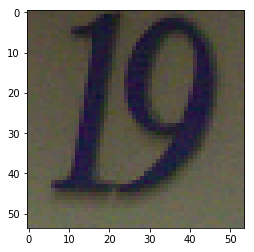

In [131]:
#Split to train and validation set and prepocess data by substracting mean and divided by 255
n=1000
n_train = int(n*0.8)
Pic_crop_Final = test_set["images"]
plt.imshow(Pic_crop_Final[0].reshape([54,54,3]))
x_train = np.array(Pic_crop_Final[:n_train])
x_val = np.array(Pic_crop_Final[n_train:n])
mean_image = np.mean(x_train, axis=0)
x_train = x_train.astype(np.float32) - mean_image.astype(np.float32)
x_val = x_val.astype(np.float32) - mean_image

x_train = x_train.reshape([-1,54,54,3])
x_val = x_val.reshape([-1,54,54,3])

#training label need one-hot encoded format
y_train= np.array(thats_hot[:n_train])
#validation label is original format
y_val=np.array(label_train_int[n_train:n])
y_val2 = np.array(label_train_int[:n_train])

##### After the mean is substracted

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[51 36 35 48 26  4 28 24 33 57 19 10 50 21 10 13 22 24 68 59 27 93 27 93
  2 56 89 12  9  3 87 47 10 86 40 56 30 98 65 51 24 38 11 48 24  5 56 33
  1 10 28 32 95 12 65 10 30 21 58 47 58 45 22  7 54 79 64 28 40 47 38 73
 15  2 82 91 19 53  7 68  8 81 18 75 36 45 30 43 48  3 27 43 64 17  5 55
 62  4 14 31 24  6 88 62 68 21 35 32 89 48  2 63  5 55 57 81 36  6 39 34
 16 46 35 10 47 13  2 24 67 10  2  2 19 36 84 33  5 41 38 10 38 36 18 58
 41  2 50  5 40 23 90 45 10 45  8 62 19  0 40 27 36 30 11 11 19 48 60 71
 13  7 94 50  3 50 52 23 30 27 23 17 94 72 11  2 13 47 57 21 17 50  2 29
 16 78 30  5  4  8 85 25]


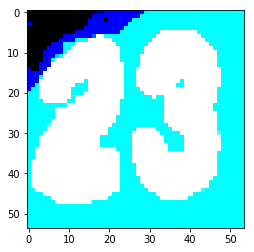

In [142]:
print(y_train[1])
plt.imshow(x_train[1])

##### We modified the output to have 100 units ( former one had 7+11*5 = 62 units)

In [147]:
def model (x, y, is_training=True, drop_rate=0.9):
    if is_training == False:
        drop_rate=0


    with tf.variable_scope('CNN_1'):
        conv = tf.layers.conv2d(x, filters=48, kernel_size=[5, 5], padding='same')
        norm = tf.layers.batch_normalization(conv)
        activation = tf.nn.relu(norm)
        pool = tf.layers.max_pooling2d(activation, pool_size=[2, 2], strides=2, padding='same')
        hidden1 = pool  # 27 * 27 * 48
        # print(hidden1.shape)

    with tf.variable_scope('CNN_2'):
        conv = tf.layers.conv2d(hidden1, filters=64, kernel_size=[5, 5], padding='same')
        norm = tf.layers.batch_normalization(conv)
        activation = tf.nn.relu(norm)
        pool = tf.layers.max_pooling2d(activation, pool_size=[2, 2], strides=1, padding='same')
        hidden2 = pool  # 27 * 27 * 64
        # print(hidden2.shape)

    with tf.variable_scope('CNN_3'):
        conv = tf.layers.conv2d(hidden2, filters=128, kernel_size=[5, 5], padding='same')
        norm = tf.layers.batch_normalization(conv)
        activation = tf.nn.relu(norm)
        pool = tf.layers.max_pooling2d(activation, pool_size=[2, 2], strides=2, padding='same')
        hidden3 = pool  # 14 * 14 * 128
        # print(hidden3.shape)

    with tf.variable_scope('CNN_4'):
        conv = tf.layers.conv2d(hidden3, filters=160, kernel_size=[5, 5], padding='same')
        norm = tf.layers.batch_normalization(conv)
        activation = tf.nn.relu(norm)
        pool = tf.layers.max_pooling2d(activation, pool_size=[2, 2], strides=1, padding='same')
        hidden4 = pool  # 14 * 14 *160
        # print(hidden4.shape)

    with tf.variable_scope('CNN_5'):
        conv = tf.layers.conv2d(hidden4, filters=192, kernel_size=[5, 5], padding='same')
        norm = tf.layers.batch_normalization(conv)
        activation = tf.nn.relu(norm)
        pool = tf.layers.max_pooling2d(activation, pool_size=[2, 2], strides=2, padding='same')
        hidden5 = pool  # 7 * 7 * 192
        # print(hidden5.shape)

    with tf.variable_scope('CNN_6'):
        conv = tf.layers.conv2d(hidden5, filters=192, kernel_size=[5, 5], padding='same')
        norm = tf.layers.batch_normalization(conv)
        activation = tf.nn.relu(norm)
        pool = tf.layers.max_pooling2d(activation, pool_size=[2, 2], strides=1, padding='same')
        hidden6 = pool  # 7 * 7 * 192
        # print(hidden6.shape)

    with tf.variable_scope('CNN_7'):
        conv = tf.layers.conv2d(hidden6, filters=192, kernel_size=[5, 5], padding='same')
        norm = tf.layers.batch_normalization(conv)
        activation = tf.nn.relu(norm)
        pool = tf.layers.max_pooling2d(activation, pool_size=[2, 2], strides=2, padding='same')
        hidden7 = pool  # 4 * 4 * 192
        # print(hidden7.shape)

    with tf.variable_scope('CNN_8'):
        conv = tf.layers.conv2d(hidden7, filters=192, kernel_size=[5, 5], padding='same')
        norm = tf.layers.batch_normalization(conv)
        activation = tf.nn.relu(norm)
        pool = tf.layers.max_pooling2d(activation, pool_size=[2, 2], strides=1, padding='same')
        hidden8 = pool  # 4 * 4 * 192

    flatten = tf.reshape(hidden8, [-1, 4 * 4 * 192])

    with tf.variable_scope('Hidden_1'):
        dense = tf.layers.dense(flatten, units=1000, activation=tf.nn.relu)
        dropout = tf.layers.dropout(dense, rate=drop_rate)
        hidden9 = dropout

    with tf.variable_scope('Hidden_2'):
        dense = tf.layers.dense(hidden9, units=1000, activation=tf.nn.relu)
        dropout = tf.layers.dropout(dense, rate=drop_rate)
        hidden10 = dropout

    with tf.variable_scope('outpur_layer'):
        output = tf.layers.dense(hidden10, units=100)
    with tf.variable_scope('prediction'):
        pred = tf.argmax(output,axis=1)
        
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits (labels=y, logits=output))
    
    return loss,pred

#### To train

In [225]:
tf.reset_default_graph()
with tf.name_scope('inputs'):
    x = tf.placeholder(tf.float32, shape=(None,54,54,3))
    y = tf.placeholder(tf.int64, shape=(None,None))
    is_training = tf.placeholder(tf.bool, name='is_training')
loss,pred = model(x, y, is_training)
train_step = tf.train.AdamOptimizer(1e-5).minimize(loss)
num_train = x_train.shape[0]
batch_size = 32
epoches = 50
num_batch = num_train//batch_size


iter_total = 0
cur_model_name = 'SVHN_{}'.format(int(time.time()))
best_acc=0
with tf.Session() as sess:
#     merge = tf.summary.merge_all()
#     writer = tf.summary.FileWriter("log/{}".format(cur_model_name), sess.graph)
    sess.run(tf.initialize_all_variables())
    saver = tf.train.Saver()
    for e in range(epoches):
        print("epoch {} ".format(e + 1))
        for i in range(num_batch):
            iter_total += 1
            choice=np.random.choice(num_train, size=batch_size, replace=False)
            batch_x, batch_y = x_train[choice], y_train[choice]
            _, loss_tf = sess.run([train_step,loss], feed_dict={x:batch_x , y:batch_y ,is_training: True})
            pred_tf =sess.run([pred], feed_dict={x:x_train ,is_training: True})
            pred_tf = pred_tf[0]
            diff = pred_tf - y_val2
            valid_acc = 1  - np.count_nonzero(diff)/diff.shape[0]
            valid_acc = valid_acc*100
            if iter_total % 10 == 0:
                
                print('{} batch training loss: {} validation accuracy : {}%'.format(i,loss_tf,valid_acc))
                
                if valid_acc > best_acc:
                    best_acc = valid_acc                
                    saver.save(sess, 'model/{}'.format(cur_model_name))
                    print('Best validation accuracy: {}%'.format(best_acc))
print("Traning ends. The best valid accuracy is {}. Model named {}.".format(best_acc, cur_model_name))





epoch 1 
9 batch training loss: 4.55126953125 validation accuracy : 3.0000000000000027%
Best validation accuracy: 3.0000000000000027%
19 batch training loss: 4.428492546081543 validation accuracy : 3.874999999999995%
Best validation accuracy: 3.874999999999995%
epoch 2 
4 batch training loss: 4.34456729888916 validation accuracy : 3.874999999999995%
14 batch training loss: 4.246374607086182 validation accuracy : 4.249999999999998%
Best validation accuracy: 4.249999999999998%
24 batch training loss: 4.309713363647461 validation accuracy : 4.625000000000002%
Best validation accuracy: 4.625000000000002%
epoch 3 
9 batch training loss: 4.3188157081604 validation accuracy : 4.5000000000000036%
19 batch training loss: 4.268525123596191 validation accuracy : 4.749999999999998%
Best validation accuracy: 4.749999999999998%
epoch 4 
4 batch training loss: 4.284451484680176 validation accuracy : 5.125000000000002%
Best validation accuracy: 5.125000000000002%
14 batch training loss: 4.279767036437

24 batch training loss: 1.1782491207122803 validation accuracy : 83.375%
Best validation accuracy: 83.375%
epoch 35 
9 batch training loss: 0.5454978942871094 validation accuracy : 86.625%
Best validation accuracy: 86.625%
19 batch training loss: 0.6232023239135742 validation accuracy : 88.75%
Best validation accuracy: 88.75%
epoch 36 
4 batch training loss: 0.8401914834976196 validation accuracy : 91.25%
Best validation accuracy: 91.25%
14 batch training loss: 0.8072823286056519 validation accuracy : 90.625%
24 batch training loss: 0.6186333894729614 validation accuracy : 89.125%
epoch 37 
9 batch training loss: 0.7968412041664124 validation accuracy : 92.0%
Best validation accuracy: 92.0%
19 batch training loss: 0.6609213352203369 validation accuracy : 94.25%
Best validation accuracy: 94.25%
epoch 38 
4 batch training loss: 0.354885458946228 validation accuracy : 94.25%
14 batch training loss: 0.5346921682357788 validation accuracy : 91.25%
24 batch training loss: 0.32194313406944275

In [226]:
pred_tf

array([19, 23, 25, 93, 31, 33, 28, 16, 23, 63, 42, 58, 16, 23, 79, 53, 62,
        2, 47, 89, 24, 56, 52, 14, 43, 14, 42,  6, 44, 11, 17, 31, 20, 42,
       29, 10, 24, 46, 91, 35, 93, 11, 56, 11,  2, 47,  5, 32, 43, 29, 58,
       95, 10, 44, 31, 15,  3, 33, 18, 98, 22, 74, 45, 60,  3, 17, 35, 17,
        5, 18, 35, 17, 12, 18, 36,  2, 53, 35,  7, 14, 14, 52,  2, 30, 63,
        9, 13, 19, 32, 48, 51, 17,  6,  5, 64,  8, 13, 68,  4, 98, 44,  9,
       68,  2, 10, 46, 28,  9, 39,  4, 41, 33, 15, 47, 33, 19,  2,  7,  6,
       57,  2, 91, 85,  3,  5, 15, 42, 76, 21, 11, 59,  5, 21, 25, 37, 34,
       21, 19, 45,  9, 26,  3,  1, 43, 12,  1, 20, 23,  4, 49, 49,  9, 26,
       27, 29,  1,  8,  2, 18, 51,  2, 68,  2,  1, 72,  3, 10, 84, 77, 39,
       15, 15, 15, 38, 51,  2,  7, 10, 78, 76, 19, 35, 93, 28, 11, 56,  5,
       36, 14, 71, 76, 50, 21,  6, 19,  9, 25, 57, 14, 11,  1, 29, 37, 11,
       61, 13, 41, 11, 11,  4, 74, 11, 33, 60, 79,  9,  6, 50, 23, 17, 87,
       23, 68, 13, 12, 14